<hr style="border-width:2px;border-color:#75DFC1">
<center><h1> Évaluation de la potabilité de l'eau </h1></center>
<hr style="border-width:2px;border-color:#75DFC1">

## 1. Introduction 

L'objectif de ce projet est de déterminer à partir d'un jeu de données si une eau est potable ou non.
>
> * Les normes imposées par l'OMS pour définir si l'eau est potable ou non sont les suivantes : 
>
>> - **6.5 < pH < 8.5**
>> - Desirable limit: **Solids < 500 mg/L** | Maximum limit: **Solids < 1000 mg/L**
>> - **Chloramines < 4 mg/L** (= 4 ppm)
>> - In seawater: **Sulfate ~ 2.7 mg/L** | In most fresh water supplies: **3 < Sulfate < 30 mg/L** | In some geographic locations: **Sulfate = 1000 mg/L** 
>> - **Conductivity < 400 µS/cm**
>> - **Organic_carbon < 2 mg/L** in treated/drinking water | **Organic_carbon < 4 mg/L** in source water used for treatment
>> - **Trihalomethanes < 80 ppm**
>> - Recommended value: **Turbidity = 5.00 NTU**



> * Importons toutes les bibliothèques nécessaires pour le projet

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
#from utils import process_remove_outliers_ph, process_remove_outliers_quartile
import os

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

from numpy import percentile

import warnings
warnings.filterwarnings("ignore")

## 2. Exploration des données 

### Affichage et description du jeu de données

In [35]:
df = pd.read_csv("drinking_water_potability.csv")

df.head(15)



,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.68774,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.71654,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.09176,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.58385,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.50849,9.077200,404.041635,563.885482,17.927806,71.976601,4.370562,0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
ph                 2785 non-null float64
Hardness           3276 non-null float64
Solids             3276 non-null float64
Chloramines        3276 non-null float64
Sulfate            2495 non-null float64
Conductivity       3276 non-null float64
Organic_carbon     3276 non-null float64
Trihalomethanes    3114 non-null float64
Turbidity          3276 non-null float64
Potability         3276 non-null int64
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [37]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


### Analyse Univariée

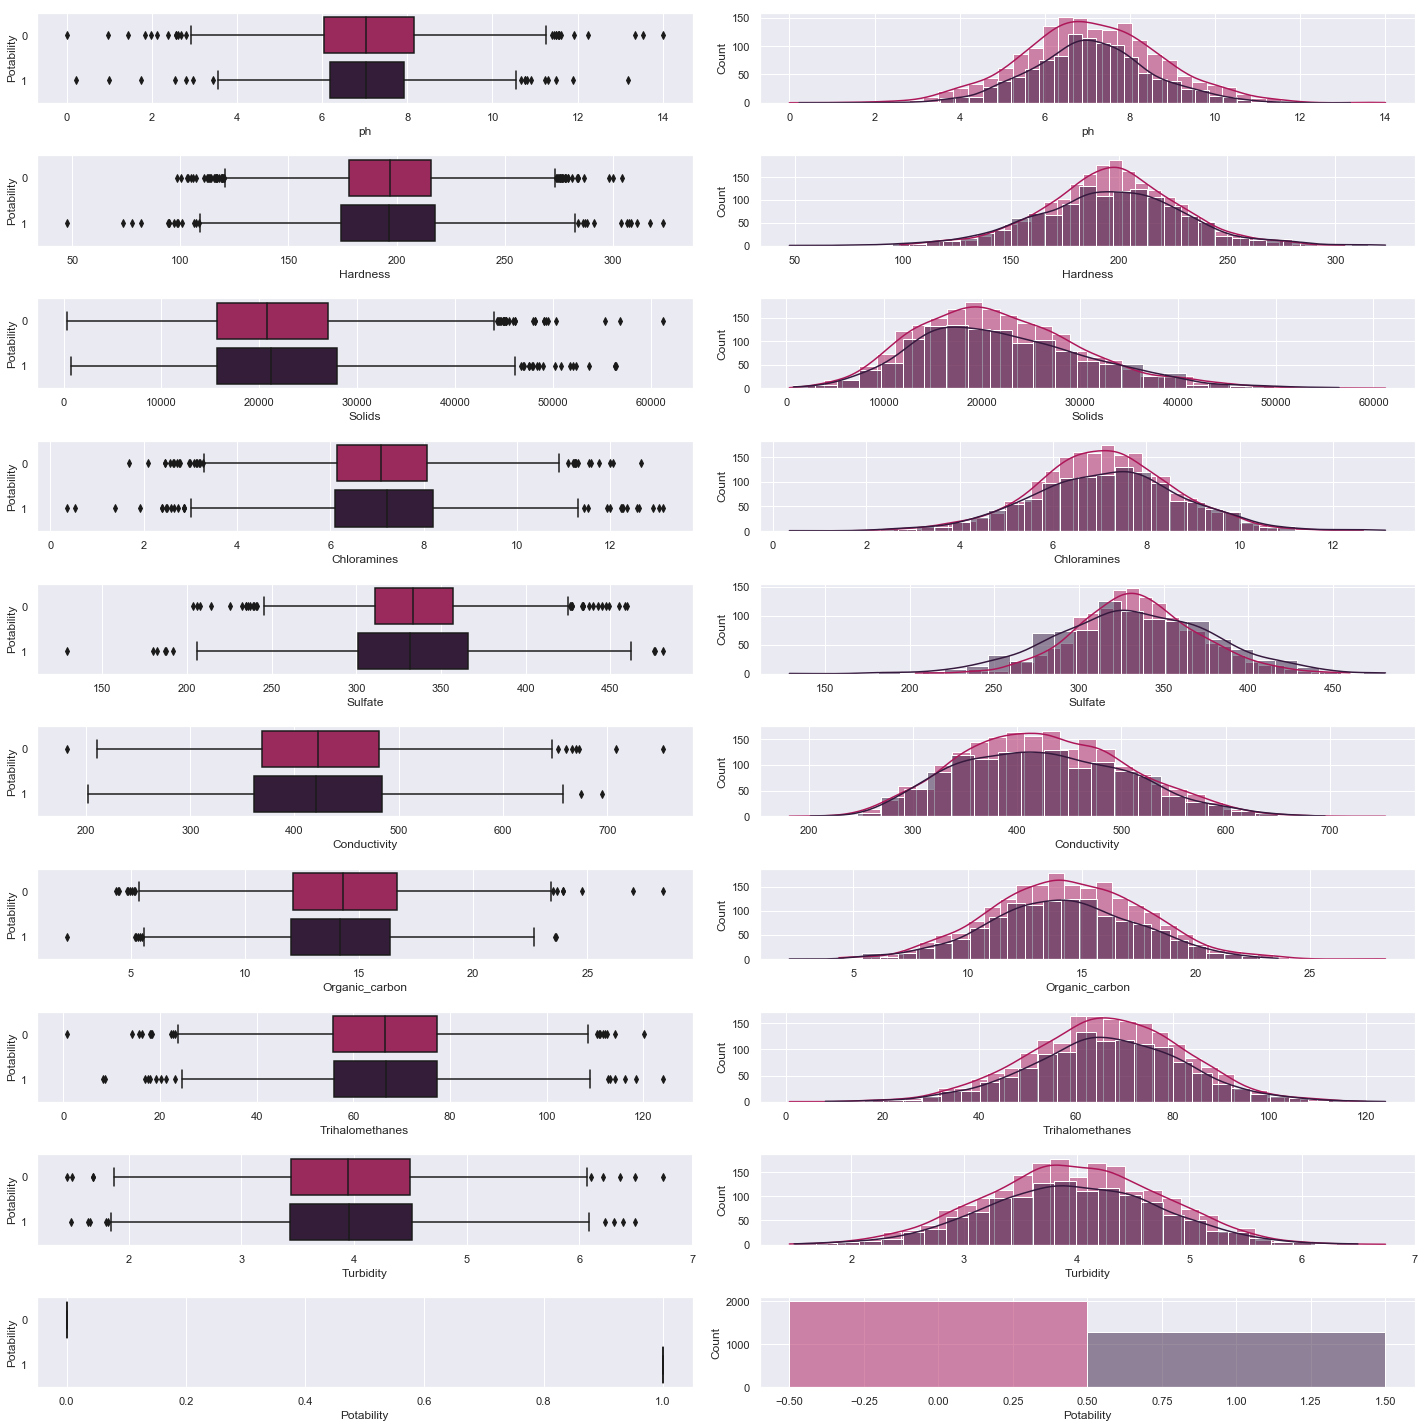

In [38]:
#Affichage de boîtes à moustaches et histogrammes pour analyser les distributions de chacunes des features
# ainsi que pour identifier d'éventuelles valeurs aberrantes 

sns.set_theme() 
sns.set(palette = "rocket")

fig, ax = plt.subplots(len(df.columns), 2, figsize = (20, 20))
for i in range(len(df.columns)):
    y_not_potable=df[df.columns[i]].loc[df["Potability"]==0]
    y_potable=df[df.columns[i]].loc[df["Potability"]==1]
    sns.histplot(y_not_potable, ax = ax[i,1], kde=True, color="C2")
    sns.histplot(y_potable, ax = ax[i,1], kde=True, color="C6")
    sns.boxplot(y=df["Potability"], x=df[df.columns[i]], ax = ax[i,0], orient="h", palette={0: "C2", 1: "C6"})
plt.tight_layout()

## Data processing

### Gestion des outliers avec la méthode IQR

In [56]:
df_train,df_test=train_test_split(df,train_size=0.8,random_state=0,stratify=df['Potability'])

train_proportion_potable = df_train.Potability[df_train['Potability']==1].value_counts()/df_train.shape[0]
train_proportion_notpotable = df_train.Potability[df_train['Potability']==0].value_counts()/df_train.shape[0]

test_proportion_potable = df_test.Potability[df_test['Potability']==1].value_counts()/df_test.shape[0]
test_proportion_notpotable = df_test.Potability[df_test['Potability']==0].value_counts()/df_test.shape[0]

print(f"Proportions de la target Potability dans le train set :\n Potable: {train_proportion_potable[1]}, \n Non Potable: {train_proportion_notpotable[0]}")

print(f"Proportions de la target Potability dans le test set :\n Potable: {test_proportion_potable[1]}, \n Non Potable: {test_proportion_notpotable[0]}")

Proportions de la target Potability dans le train set :
 Potable: 0.3900763358778626, 
 Non Potable: 0.6099236641221374
Proportions de la target Potability dans le test set :
 Potable: 0.3902439024390244, 
 Non Potable: 0.6097560975609756


In [68]:
##Definition de la fonction pour drop les data points qui s'écartent de 1.5*IQR sur chaque feature
def remove_outliers_IQR(df):
    df_copy=df.copy()
    for feature in df.columns:
        Q25,Q75=df[feature].quantile(0.25),df[feature].quantile(0.75)
        cutoff=(Q75-Q25)*1.5
        lower, upper = Q25 - cutoff, Q75 + cutoff
        indexes_to_drop=df_copy[(df_copy[feature] <= lower) | (df_copy[feature] >= upper)].index
        df_copy = df_copy.drop(indexes_to_drop)
    return df_copy
        
train_outliers_removed=remove_outliers_IQR(df_train)
test_outliers_removed=remove_outliers_IQR(df_test)

In [69]:
print(f"En pourcentage, le nombre de lignes supprimées par l'IQR dans le train est de : "+ str(100*round(((train_outliers_removed.shape[0]-df_train.shape[0])/df_train.shape[0]),2))+"%")
print(f"En pourcentage, le nombre de lignes supprimées par l'IQR dans le test est de : "+ str(100*round(((test_outliers_removed.shape[0]-df_test.shape[0])/df_test.shape[0]),2))+"%")

En pourcentage, le nombre de lignes supprimées par l'IQR dans le train est de : -10.0%
En pourcentage, le nombre de lignes supprimées par l'IQR dans le test est de : -12.0%


In [70]:
df_train=train_outliers_removed
df_test=test_outliers_removed